In [298]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

In [299]:
df = pd.read_csv(r"Churn_Banking_Modeling.csv")
df = df.drop('Id_Cliente',axis=1)
df.head()

,Flag_Richiesta_Estinzione_cc,Imp_Valore_del_Cliente,Flag_Apertura_Conto_Online,Flag_Possesso_piu_Conti,Eta,Provincia_Domicilio,Provincia_Residenza,Anno_Apertura_primo_Conto,Professione,Imp_Reddito,...,Imp_Liquidit�_Attuale,Imp_Gestito_attuale,Imp_Amministrato_attuale,Imp_Liquidit�_Attuale_6m,Imp_Gestito_attuale_6m,Imp_Amministrato_attuale_6m,Flag_Trasferimento_Titoli_Out,Flag_Rifiuto_Carte,Flag_Rifiuto_Prestiti,Flag_Disattivazione_RID
0,no,65.03,0,0,38.0,BO,BO,2004.0,Impiegato,Medio (tra 1500 e 1800),...,1634.57,2978.40,2980.92,1550.44,2853.2,2853.22,0,0,0,0
1,no,138.88,0,0,45.0,SA,SA,2000.0,Impiegato,Alto (tra 1800 e 2500),...,11918.26,NaN,34916.15,26122.17,NaN,22053.82,0,0,0,0
2,no,546.54,0,0,61.0,VT,VT,2005.0,Altro/Nessuno,Alto (tra 1800 e 2500),...,2671.95,NaN,232776.62,16545.25,NaN,216304.33,1,0,0,0
3,no,68.69,0,0,33.0,MI,MI,2010.0,Impiegato,Basso (tra 1200 e 1500),...,19211.31,15013.53,15017.53,12500.00,NaN,NaN,0,0,0,0
4,no,2417.05,0,0,36.0,MI,MI,2001.0,Quadro,NaN,...,1526.38,NaN,NaN,1427.70,NaN,21514.60,0,0,0,0


In [300]:
# nella creazione delle dummies vengono usati caratteri speciali nei nomi delle colonne, li rimpiazziamo
def clean_feature_names(df):
    df.columns = [col.replace(' ', '_').replace('[', '').replace(']', '').replace('<', '') for col in df.columns]
    return df

In [301]:
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1}) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

XX = pd.get_dummies(X)
missing_columns_train = set(XX.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(XX.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[XX.columns]
X_test = X_test[XX.columns]


X_train_res = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

X_train_res = clean_feature_names(X_train_res)
X_test = clean_feature_names(X_test)
X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)

count_ones = np.sum(y_test == 1)
print("Numero di volte che y_test è uguale a 1:", count_ones)

C:\Users\emanu\AppData\Local\Temp\ipykernel_24736\599968847.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[col] = 0
C:\Users\emanu\AppData\Local\Temp\ipykernel_24736\599968847.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[col] = 0
C:\Users\emanu\AppData\Local\Temp\ipykernel_24736\599968847.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

Numero di volte che y_test è uguale a 1: 397


Dataset Normale, senza Sampling

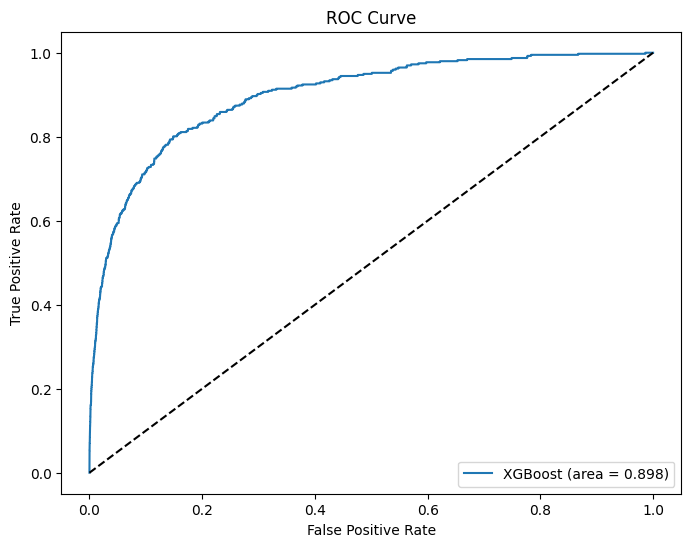

In [302]:
# Useremo sempre XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_res, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [303]:
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4) #cambiamo lo split per vedere se i nostri dati overfittano
X_train = pd.get_dummies(X_train) #dummie encoder
X_test = pd.get_dummies(X_test)
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

#problema di corrispondenza delle dummies create, le colonne non coincidono in quanto alcuni valori di Domicilio e Residenza sono unici e vengono visualizzati solo una volta nel train o test set
# per ovviare al problema ricreiamo le colonne  non corrispondenti nei df dove mancano con tutti valori = 0
missing_columns_train = set(X_train_res.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(X_train_res.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[X_train_res.columns]
X_test = X_test[X_train_res.columns]

X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# prediction usando il nostro classifier
y_pred_proba = model.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': y_pred_proba

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)
'''

"\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4) #cambiamo lo split per vedere se i nostri dati overfittano\nX_train = pd.get_dummies(X_train) #dummie encoder\nX_test = pd.get_dummies(X_test)\nX_train = clean_feature_names(X_train)\nX_test = clean_feature_names(X_test)\n\n#problema di corrispondenza delle dummies create, le colonne non coincidono in quanto alcuni valori di Domicilio e Residenza sono unici e vengono visualizzati solo una volta nel train o test set\n# per ovviare al problema ricreiamo le colonne  non corrispondenti nei df dove mancano con tutti valori = 0\nmissing_columns_train = set(X_train_res.columns) - set(X_train.columns)\nfor col in missing_columns_train:\n    X_train[col] = 0\n\nmissing_columns_test = set(X_train_res.columns) - set(X_test.columns)\nfor col in missing_columns_test:\n    X_test[col] = 0\n\nX_train = X_train[X_train_res.columns]\nX_test = X_test[X_train_res.columns]\n\nX_train, X_test = X_train.align(X_test,

In [304]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)


Numero di 'SI' nei nostri 10k: 356
Numero di 'SI: nel nostro test set 397


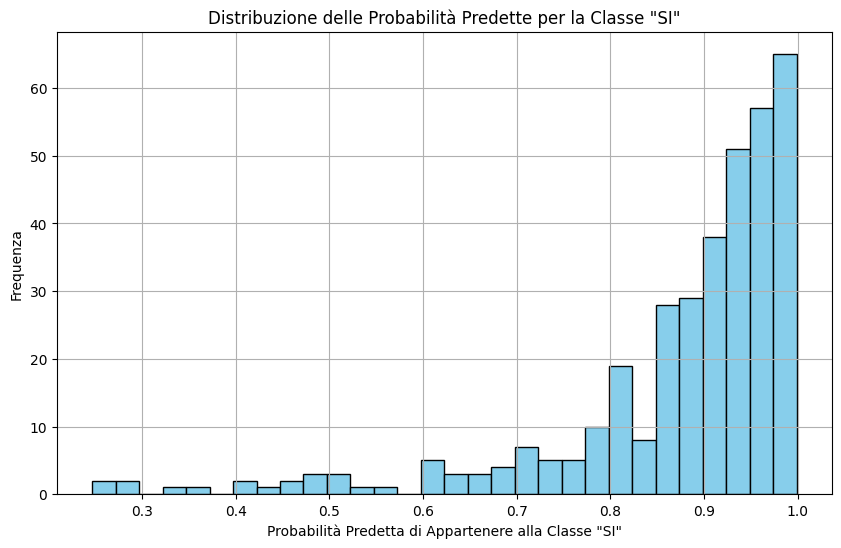

In [305]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

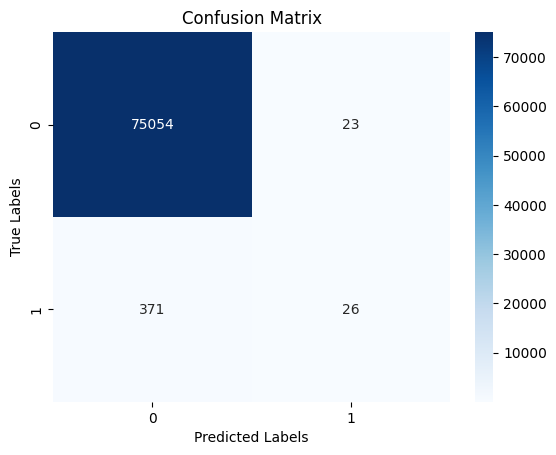

In [306]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

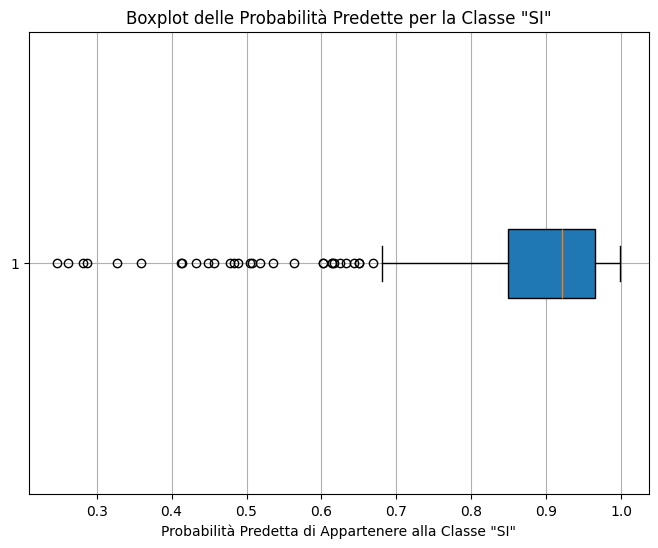

In [307]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

In [308]:
synthetic_df = pd.read_csv(r"Synthetic_dataset.csv")
synthetic_df = synthetic_df.drop('Id_Cliente',axis=1)
synthetic_df.head()
X_synthetic = synthetic_df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y_synthetic = synthetic_df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  # Converte in 0 e 1

In [309]:
X_synthetic = pd.get_dummies(X_synthetic)
X_train_synthetic = clean_feature_names(X_synthetic)

missing_columns_train = set(XX.columns) - set(X_train_synthetic.columns)
for col in missing_columns_train:
    X_train_synthetic[col] = 0  

X_train_res_synthetic = X_train_synthetic[XX.columns]

print("Training features:", X_train_res_synthetic.shape)

Training features: (5000, 295)


In [310]:
# Identify missing columns in the synthetic dataset that are present in the real dataset
missing_columns = set(X_train_res.columns) - set(X_train_res_synthetic.columns)

# Add these missing columns to the synthetic dataset and fill them with zeros
for col in missing_columns:
    X_train_res_synthetic[col] = 0

# Ensure the columns are in the same order in both datasets
X_train_res_synthetic = X_train_res_synthetic[X_train_res.columns]

# Optionally, ensure the dataframes are aligned; this step might be redundant if the previous step ensured the correct column order and completeness
X_train_res, X_train_res_synthetic = X_train_res.align(X_train_res_synthetic, join='inner', axis=1)

# Print the shape of the aligned synthetic training features to confirm the alignment
print("Training features:", X_train_res_synthetic.shape)


Training features: (5000, 295)


C:\Users\emanu\AppData\Local\Temp\ipykernel_24736\2846123168.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_res_synthetic[col] = 0
C:\Users\emanu\AppData\Local\Temp\ipykernel_24736\2846123168.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_res_synthetic[col] = 0
C:\Users\emanu\AppData\Local\Temp\ipykernel_24736\2846123168.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [311]:
lgbm_predictions = model.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_100_si = results_df_si_sorted.head(1000)
print(top_100_si)

      y_test  y_pred_proba
2814       0      0.217970
3960       0      0.215168
2645       0      0.135214
3598       0      0.128713
3859       0      0.125954
...      ...           ...
2827       0      0.003259
976        0      0.003253
2169       0      0.003252
2923       0      0.003251
203        0      0.003249

[1000 rows x 2 columns]


In [312]:
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 18
Numero di 'SI: nel nostro test set 37


UnderSampling

In [313]:
from imblearn.under_sampling import RandomUnderSampler
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})

# Splitting the data, stratifying to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Applying undersampling to balance the dataset
rus = RandomUnderSampler(sampling_strategy=0.03)  # Target ratio of 1 positive to 36 negatives
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# Converting categorical variables to dummy/indicator variables
X_train_res = pd.get_dummies(X_train_res)
X_test = pd.get_dummies(X_test)

# Ensuring that both datasets have the same feature set
# Compute all possible columns that could appear after get_dummies
all_columns = set(X_train_res.columns) | set(X_test.columns)

# Adding any missing columns with default value of 0
for column in all_columns:
    if column not in X_train_res.columns:
        X_train_res[column] = 0
    if column not in X_test.columns:
        X_test[column] = 0

# Aligning columns in training and test datasets to ensure they are in the same order
X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)

# Clean feature names if your function modifies feature naming convention
# This function should ensure valid Python identifiers for feature names if needed
X_train_res = clean_feature_names(X_train_res)
X_test = clean_feature_names(X_test)

print("Training features:", X_train_res.shape)
print("Testing features:", X_test.shape)


Training features: (54452, 290)
Testing features: (75474, 290)


In [314]:
print("Distribuzione delle classi nel dataset originale:")
print(df['Flag_Richiesta_Estinzione_cc'].value_counts())

print("Distribuzione delle classi nel dataset bilanciato:")
print(y_train_res.value_counts())

Distribuzione delle classi nel dataset originale:
Flag_Richiesta_Estinzione_cc
no    375386
si      1983
Name: count, dtype: int64
Distribuzione delle classi nel dataset bilanciato:
Flag_Richiesta_Estinzione_cc
0    52866
1     1586
Name: count, dtype: int64


In [315]:
all_columns = set(X_test.columns) | set(X_train_res_synthetic.columns)

# Adding any missing columns with default value of 0 in X_train_res
for column in all_columns:
    if column not in X_test.columns:
        X_test[column] = 0

# Adding any missing columns with default value of 0 in X_train_res_synthetic
for column in all_columns:
    if column not in X_train_res_synthetic.columns:
        X_train_res_synthetic[column] = 0

# Ensure the columns are in the same order in both dataframes
X_test = X_test[list(all_columns)]
X_train_res_synthetic = X_train_res_synthetic[list(all_columns)]

# Optionally, you can align the two dataframes to ensure they are exactly identical in format
X_test, X_train_res_synthetic = X_test.align(X_train_res_synthetic, join='inner', axis=1)

print("Aligned Training Features - Original:", X_test.shape)
print("Aligned Training Features - Synthetic:", X_train_res_synthetic.shape)


Aligned Training Features - Original: (75474, 295)
Aligned Training Features - Synthetic: (5000, 295)


In [316]:
all_columns = set(X_train_res.columns) | set(X_train_res_synthetic.columns)

# Adding any missing columns with default value of 0 in X_train_res
for column in all_columns:
    if column not in X_train_res.columns:
        X_train_res[column] = 0

# Adding any missing columns with default value of 0 in X_train_res_synthetic
for column in all_columns:
    if column not in X_train_res_synthetic.columns:
        X_train_res_synthetic[column] = 0

# Ensure the columns are in the same order in both dataframes
X_train_res = X_train_res[list(all_columns)]
X_train_res_synthetic = X_train_res_synthetic[list(all_columns)]

# Optionally, you can align the two dataframes to ensure they are exactly identical in format
X_train_res, X_train_res_synthetic = X_train_res.align(X_train_res_synthetic, join='inner', axis=1)

print("Aligned Training Features - Original:", X_train_res.shape)
print("Aligned Training Features - Synthetic:", X_train_res_synthetic.shape)


Aligned Training Features - Original: (54452, 295)
Aligned Training Features - Synthetic: (5000, 295)


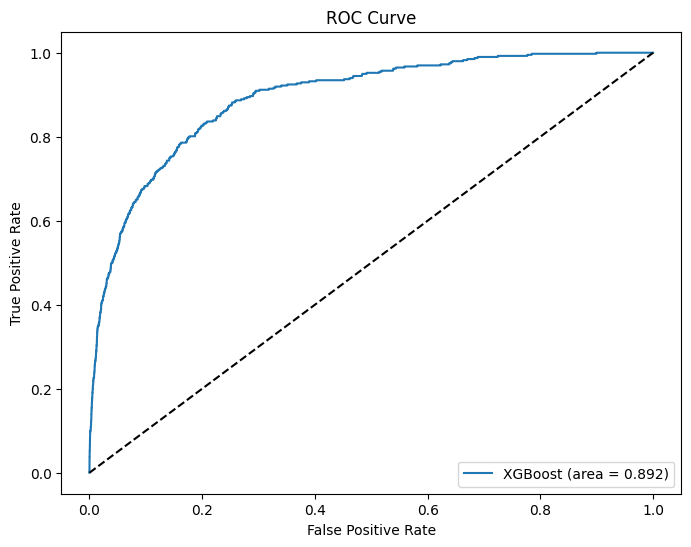

In [317]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_res, y_train_res)

y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale tratteggiata
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [318]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4) #cambiamo lo split per vedere se i nostri dati overfittano
X_train = pd.get_dummies(X_train) 
X_test = pd.get_dummies(X_test)

missing_columns_train = set(X_train_res.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(X_train_res.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[X_train_res.columns]
X_test = X_test[X_train_res.columns]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# prediction usando il nostro classifier
y_pred_proba = model.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': y_pred_proba

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)



        y_test  y_pred_proba
16142        1      0.990594
6666         1      0.990253
149699       0      0.989259
136596       0      0.988199
32           1      0.983090
...        ...           ...
302337       0      0.029474
292500       0      0.029468
296183       0      0.029463
83086        0      0.029461
46097        0      0.029459

[10000 rows x 2 columns]


In [319]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 375
Numero di 'SI: nel nostro test set 398


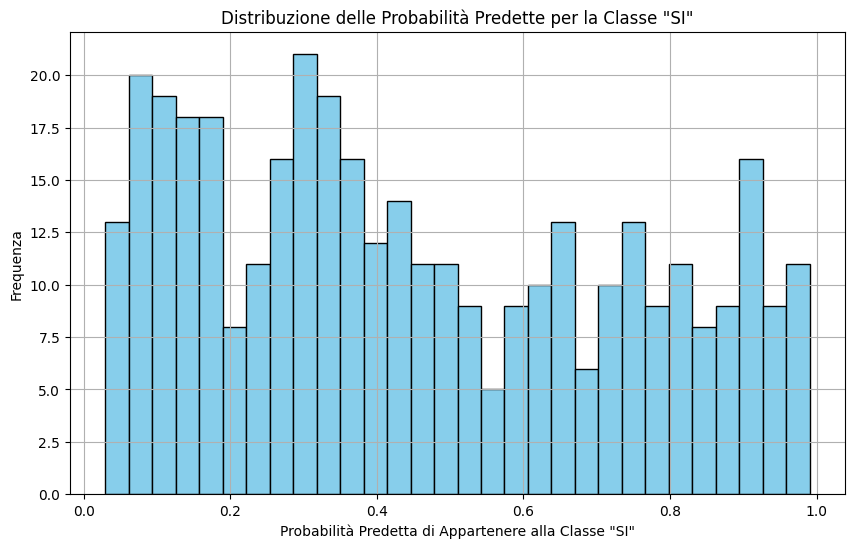

In [320]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

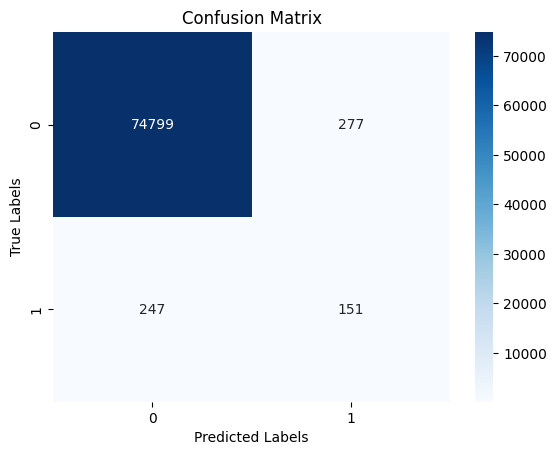

In [321]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

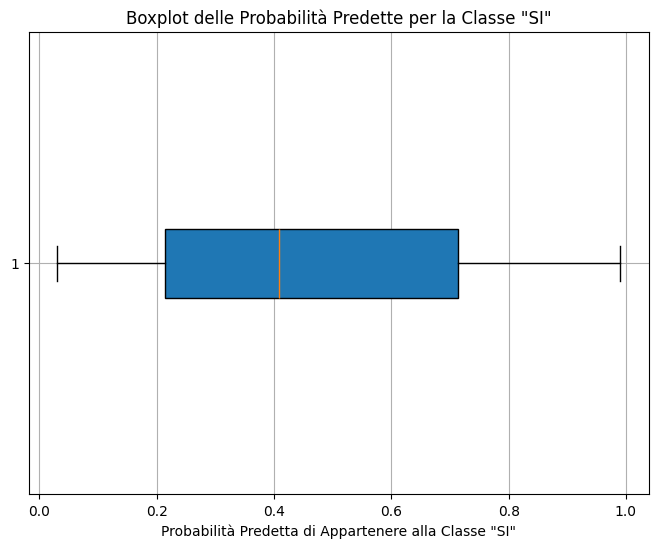

In [322]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()


In [323]:
lgbm_predictions = model.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_100_si = results_df_si_sorted.head(500)
print(top_100_si)

      y_test  y_pred_proba
2645       0      0.803859
2119       0      0.626807
2354       0      0.625543
457        0      0.599262
2814       0      0.566516
...      ...           ...
3060       0      0.039607
4968       0      0.039579
2088       0      0.039435
4087       0      0.039230
4344       0      0.039181

[500 rows x 2 columns]


In [324]:
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 13
Numero di 'SI: nel nostro test set 37


OverSampling

In [325]:
from imblearn.over_sampling import RandomOverSampler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
ros = RandomOverSampler(sampling_strategy=0.2)  
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# Converting categorical variables to dummy/indicator variables
X_train_res = pd.get_dummies(X_train_res)
X_test = pd.get_dummies(X_test)

# Ensuring that both datasets have the same feature set
# Compute all possible columns that could appear after get_dummies
all_columns = set(X_train_res.columns) | set(X_test.columns)

# Adding any missing columns with default value of 0
for column in all_columns:
    if column not in X_train_res.columns:
        X_train_res[column] = 0
    if column not in X_test.columns:
        X_test[column] = 0

# Aligning columns in training and test datasets to ensure they are in the same order
X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)

# Clean feature names if your function modifies feature naming convention
# This function should ensure valid Python identifiers for feature names if needed
X_train_res = clean_feature_names(X_train_res)
X_test = clean_feature_names(X_test)

print("Training features:", X_train_res.shape)
print("Testing features:", X_test.shape)


Training features: (54452, 291)
Testing features: (75474, 291)


In [326]:
print("Distribuzione delle classi nel dataset originale:")
print(df['Flag_Richiesta_Estinzione_cc'].value_counts())

print("Distribuzione delle classi nel dataset bilanciato:")
print(y_train_res.value_counts())

Distribuzione delle classi nel dataset originale:
Flag_Richiesta_Estinzione_cc
no    375386
si      1983
Name: count, dtype: int64
Distribuzione delle classi nel dataset bilanciato:
Flag_Richiesta_Estinzione_cc
0    52866
1     1586
Name: count, dtype: int64


In [327]:
all_columns = set(X_test.columns) | set(X_train_res_synthetic.columns)

# Adding any missing columns with default value of 0 in X_train_res
for column in all_columns:
    if column not in X_test.columns:
        X_test[column] = 0

# Adding any missing columns with default value of 0 in X_train_res_synthetic
for column in all_columns:
    if column not in X_train_res_synthetic.columns:
        X_train_res_synthetic[column] = 0

# Ensure the columns are in the same order in both dataframes
X_test = X_test[list(all_columns)]
X_train_res_synthetic = X_train_res_synthetic[list(all_columns)]

# Optionally, you can align the two dataframes to ensure they are exactly identical in format
X_test, X_train_res_synthetic = X_test.align(X_train_res_synthetic, join='inner', axis=1)

print("Aligned Training Features - Original:", X_test.shape)
print("Aligned Training Features - Synthetic:", X_train_res_synthetic.shape)


Aligned Training Features - Original: (75474, 295)
Aligned Training Features - Synthetic: (5000, 295)


In [328]:
all_columns = set(X_train_res.columns) | set(X_train_res_synthetic.columns)

# Adding any missing columns with default value of 0 in X_train_res
for column in all_columns:
    if column not in X_train_res.columns:
        X_train_res[column] = 0

# Adding any missing columns with default value of 0 in X_train_res_synthetic
for column in all_columns:
    if column not in X_train_res_synthetic.columns:
        X_train_res_synthetic[column] = 0

# Ensure the columns are in the same order in both dataframes
X_train_res = X_train_res[list(all_columns)]
X_train_res_synthetic = X_train_res_synthetic[list(all_columns)]

# Optionally, you can align the two dataframes to ensure they are exactly identical in format
X_train_res, X_train_res_synthetic = X_train_res.align(X_train_res_synthetic, join='inner', axis=1)

print("Aligned Training Features - Original:", X_train_res.shape)
print("Aligned Training Features - Synthetic:", X_train_res_synthetic.shape)


Aligned Training Features - Original: (54452, 295)
Aligned Training Features - Synthetic: (5000, 295)


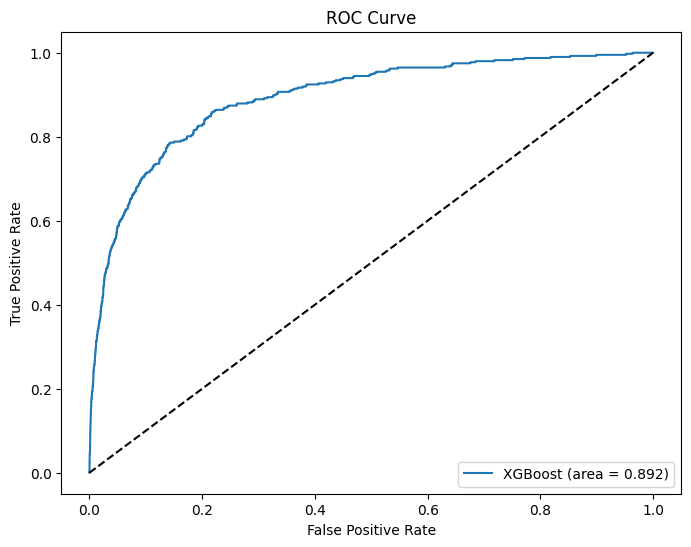

In [329]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_res, y_train_res)

y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale tratteggiata
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [330]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=49) #cambiamo lo split per vedere se i nostri dati overfittano
X_train = pd.get_dummies(X_train) 
X_test = pd.get_dummies(X_test)

missing_columns_train = set(X_train_res.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(X_train_res.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[X_train_res.columns]
X_test = X_test[X_train_res.columns]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# prediction usando il nostro classifier
y_pred_proba = model.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': y_pred_proba

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)


        y_test  y_pred_proba
54651        1      0.997738
148527       0      0.989179
17364        1      0.987016
13906        1      0.985956
62554        1      0.984698
...        ...           ...
105071       0      0.030322
161472       0      0.030314
140788       0      0.030313
299607       0      0.030308
326083       0      0.030304

[10000 rows x 2 columns]


In [331]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 341
Numero di 'SI: nel nostro test set 360


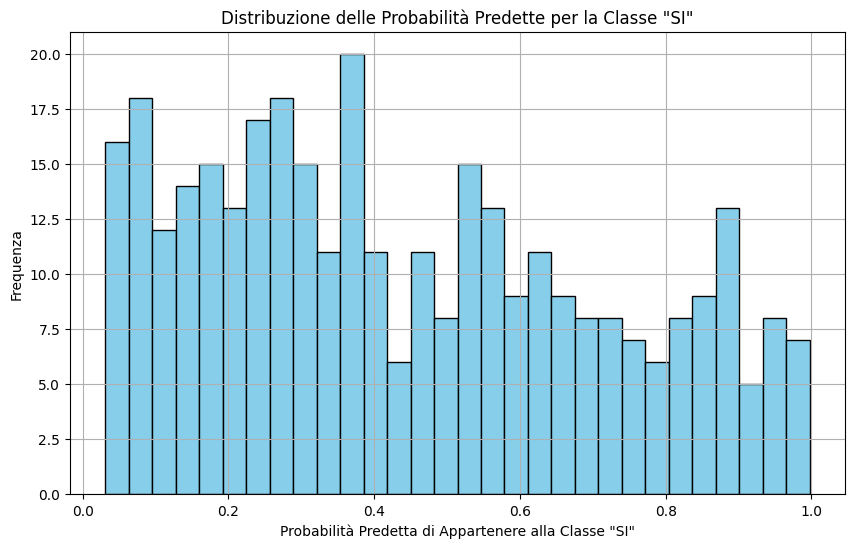

In [332]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

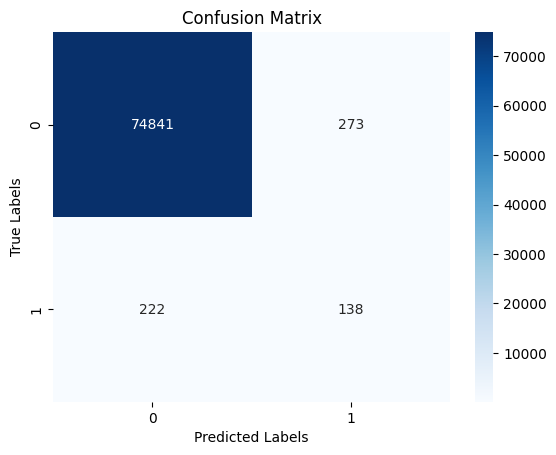

In [333]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

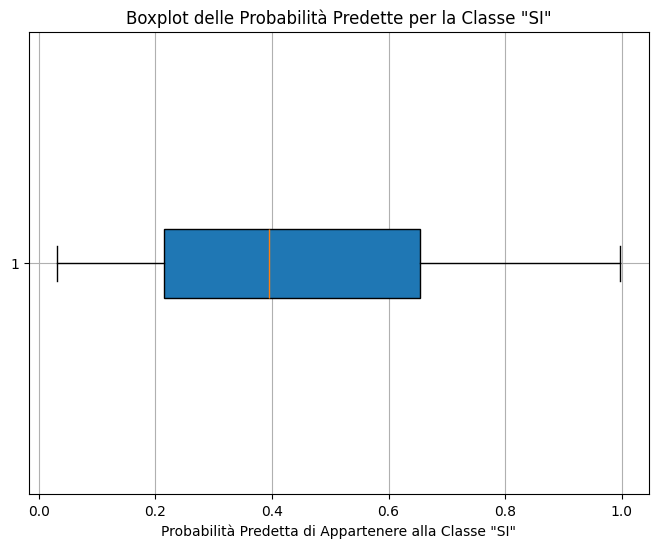

In [334]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

In [335]:
lgbm_predictions = model.predict_proba(X_train_res_synthetic)[:, 1]

In [336]:
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_100_si = results_df_si_sorted.head(1000)
print(top_100_si)

      y_test  y_pred_proba
2174       0      0.686959
2151       0      0.685794
457        0      0.663257
2119       0      0.631033
4378       0      0.590176
...      ...           ...
4183       0      0.016697
304        0      0.016669
1872       0      0.016621
2299       0      0.016620
2391       0      0.016548

[1000 rows x 2 columns]


In [337]:
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 19
Numero di 'SI: nel nostro test set 10


Balanced Boosting con Cost-Sensitive Learning

In [338]:
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1}) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

XX = pd.get_dummies(X)
missing_columns_train = set(XX.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(XX.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[XX.columns]
X_test = X_test[XX.columns]


X_train_res = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

X_train_res = clean_feature_names(X_train_res)
X_test = clean_feature_names(X_test)
X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)

count_ones = np.sum(y_test == 1)
print("Numero di volte che y_test è uguale a 1:", count_ones)

C:\Users\emanu\AppData\Local\Temp\ipykernel_24736\599968847.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[col] = 0
C:\Users\emanu\AppData\Local\Temp\ipykernel_24736\599968847.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[col] = 0
C:\Users\emanu\AppData\Local\Temp\ipykernel_24736\599968847.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

Numero di volte che y_test è uguale a 1: 397


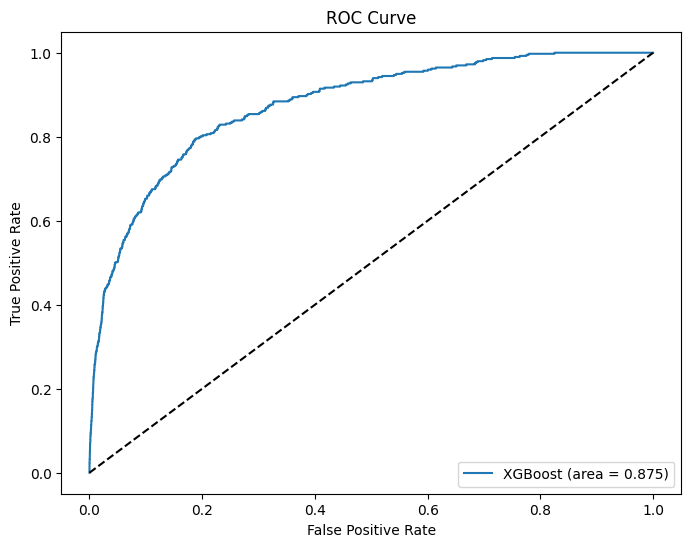

In [339]:
scale_pos_weight = len(y[y == 0]) / len(y[y == 1]) # sbilanciamento tra le classi

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    scale_pos_weight=scale_pos_weight, 
    use_label_encoder=False, 
    eval_metric='logloss'
)

model.fit(X_train_res, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calcolo della curva ROC e dell'AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Visualizzazione della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale tratteggiata
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [340]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3) #cambiamo lo split per vedere se i nostri dati overfittano
X_train = pd.get_dummies(X_train) 
X_test = pd.get_dummies(X_test)

missing_columns_train = set(X_train_res.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(X_train_res.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[X_train_res.columns]
X_test = X_test[X_train_res.columns]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# prediction usando il nostro classifier
y_pred_proba = model.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': y_pred_proba

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
20382        1      0.998403
4377         1      0.998090
743          0      0.997698
6060         1      0.997557
19464        1      0.996365
...        ...           ...
365431       0      0.239833
178386       0      0.239775
12459        0      0.239754
15228        0      0.239670
247254       0      0.239663

[10000 rows x 2 columns]


In [341]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 364
Numero di 'SI: nel nostro test set 383


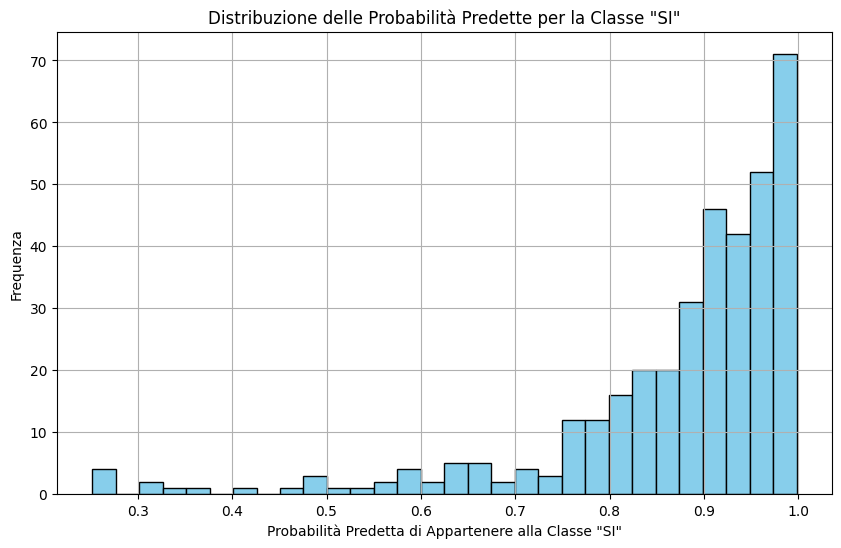

In [342]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

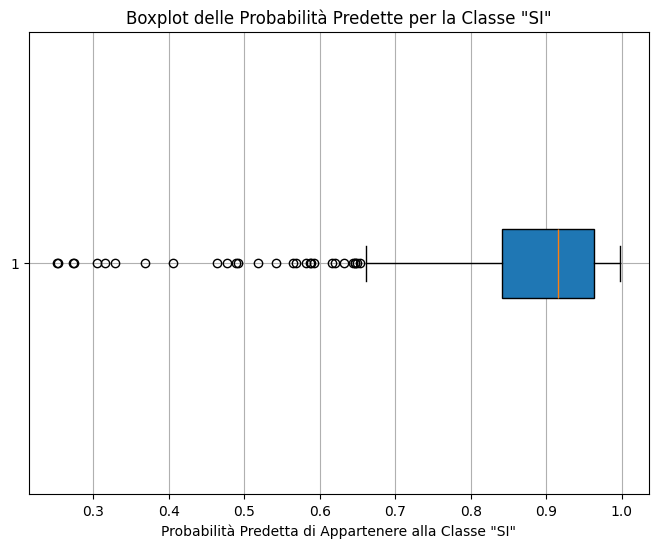

In [343]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

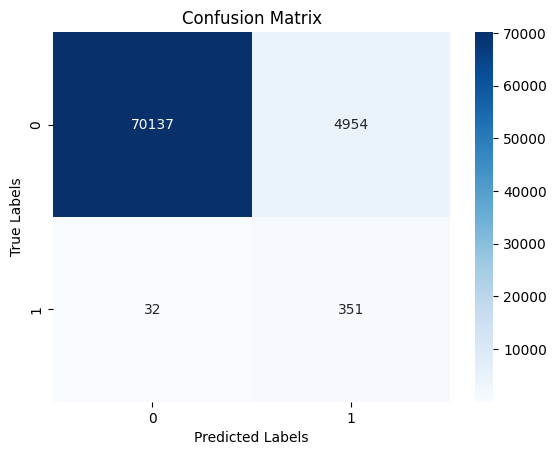

In [344]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [345]:
synthetic_df = pd.read_csv(r"Synthetic_dataset.csv")
synthetic_df = synthetic_df.drop('Id_Cliente',axis=1)
synthetic_df.head()
X_synthetic = synthetic_df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y_synthetic = synthetic_df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  # Converte in 0 e 1
X_synthetic = pd.get_dummies(X_synthetic)
X_train_synthetic = clean_feature_names(X_synthetic)

missing_columns_train = set(XX.columns) - set(X_train_synthetic.columns)
for col in missing_columns_train:
    X_train_synthetic[col] = 0  

X_train_res_synthetic = X_train_synthetic[XX.columns]

print("Training features:", X_train_res_synthetic.shape)
missing_columns = set(X_train_res.columns) - set(X_train_res_synthetic.columns)

# Add these missing columns to the synthetic dataset and fill them with zeros
for col in missing_columns:
    X_train_res_synthetic[col] = 0

# Ensure the columns are in the same order in both datasets
X_train_res_synthetic = X_train_res_synthetic[X_train_res.columns]

# Optionally, ensure the dataframes are aligned; this step might be redundant if the previous step ensured the correct column order and completeness
X_train_res, X_train_res_synthetic = X_train_res.align(X_train_res_synthetic, join='inner', axis=1)

# Print the shape of the aligned synthetic training features to confirm the alignment
print("Training features:", X_train_res_synthetic.shape)


Training features: (5000, 295)
Training features: (5000, 295)


C:\Users\emanu\AppData\Local\Temp\ipykernel_24736\804254559.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_res_synthetic[col] = 0
C:\Users\emanu\AppData\Local\Temp\ipykernel_24736\804254559.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_res_synthetic[col] = 0
C:\Users\emanu\AppData\Local\Temp\ipykernel_24736\804254559.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [346]:
lgbm_predictions = model.predict_proba(X_train_res_synthetic)[:, 1]

In [347]:
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_100_si = results_df_si_sorted.head(1000)
print(top_100_si)

      y_test  y_pred_proba
2082       1      0.986867
2814       0      0.963891
2354       0      0.958569
4202       0      0.957185
720        0      0.946843
...      ...           ...
4426       0      0.102182
2044       0      0.102063
2863       0      0.102016
4652       0      0.101856
3317       0      0.101661

[1000 rows x 2 columns]


In [348]:
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 19
Numero di 'SI: nel nostro test set 37


Dopo aver testato alcune tecniche per trattare i dati sbilanciati, abbiamo scelto Balanced Boosting con Cost-Sensitive Learning come piu' metodo piu' performante. E' semplice da implementare in Optuna per quanto riguarda il tuning e sopratutto ha fatto registrare i migliori risultati tra le tecniche testate. 

La confusion matrix è ottima, riesce a catturare un sacco di positivi, tende a far aumentare i Falsi Negativi ma noi questo aspetto non interessa, anzi quando andiamo a selezionare la top 10 mila andiamo a prendere decisioni piu' ragionate. Le probabilità assegnate sono alte rispetto ad altre tecniche, sinonimo che l'algoritmo è consapevole delle decisioni che svolge

E' un peccato non esser riusciti ad usare alcune tecniche di Sampling come SMOTE per quanto riguarda l'OverSampling e TomekLinks per l'UnderSampling: entrambi usano k-nearest-neighbors rispettivamente per creare nuovi campioni sintetici e rimuovere campioni di classi diversi quando sono vicini, in modo da facilitare la classificazione.
Abbiamo provato anche ad utilizzare il clustering per cercare di migliorare il bilanciamento del modello, ma da questo punto di vista i dati mancanti non ci aiutano e rendono impossibile provare altre tecniche.

Va fatto un trade off tra la perdita di informazione che otteniamo nel trattare i dati mancanti (invece di darli direttamente in pasto ai modelli di boosting) e l'informazione guadagnata nell'applicare metodi piu' sofisticati di bilanciamento dei dati. Abbiamo valutato la qualità dei nostri dati come piu' importante